/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


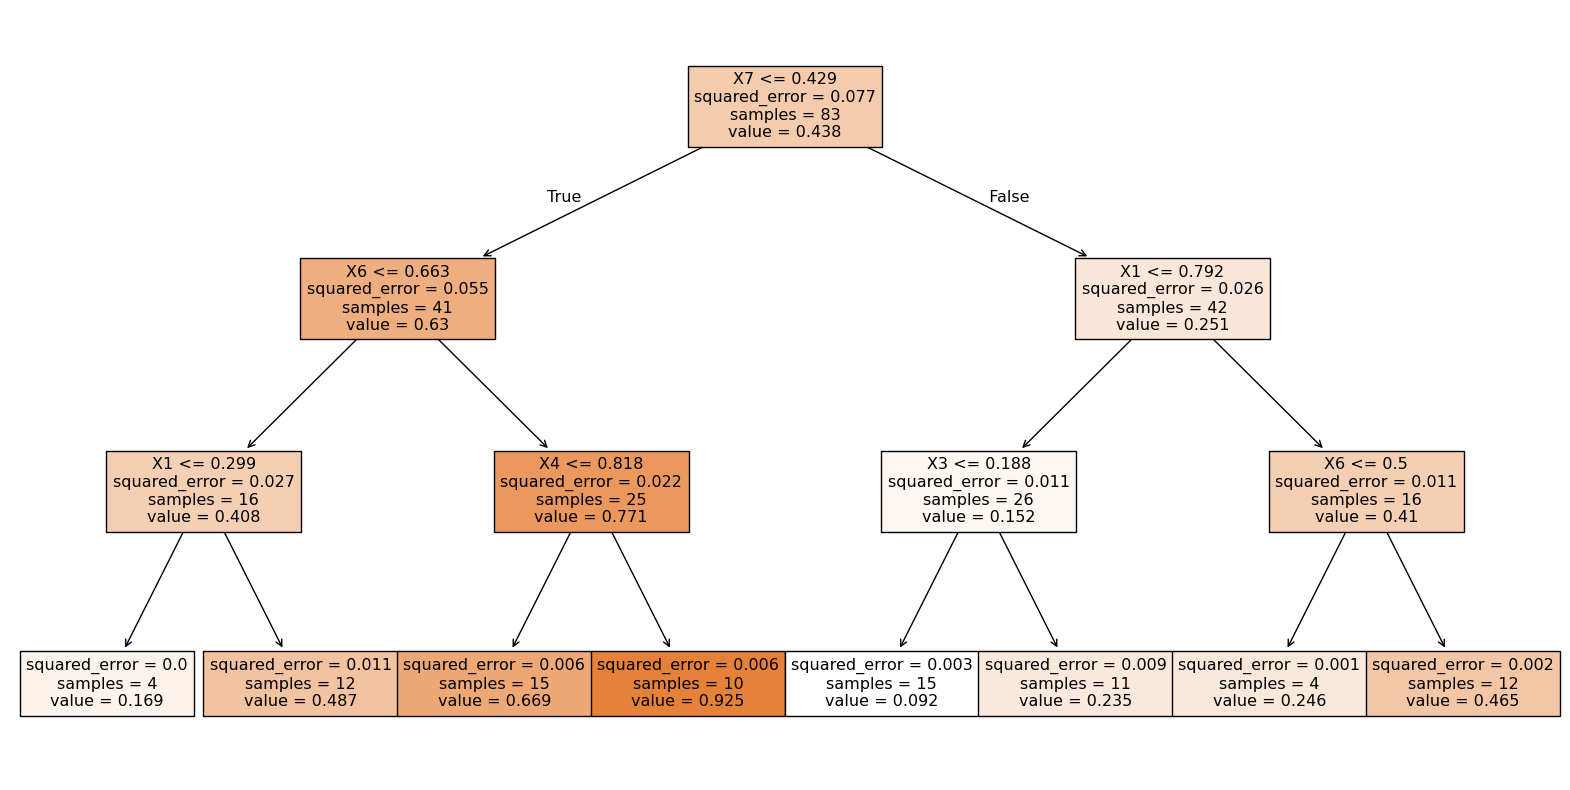

ExactExplainer explainer: 84it [00:47,  1.64it/s]


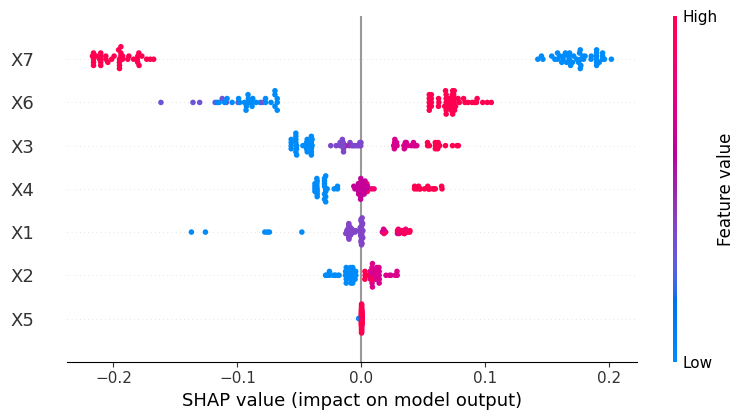

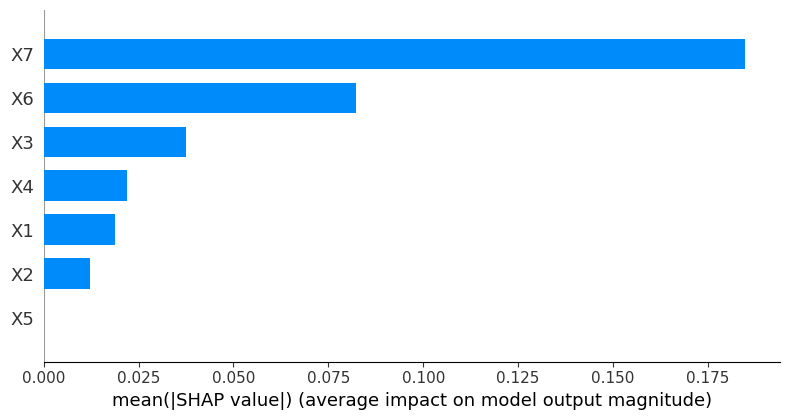

In [ ]:
import pandas as pd
import numpy as np
import openpyxl
import shap
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Load datasets
train_df = pd.read_excel("Train.xlsx")
test_df = pd.read_excel("Test.xlsx")

# Splitting data into features and target
X_train = train_df.drop(columns='Y')
y_train = train_df['Y']
X_test = test_df.drop(columns='Y')
y_test = test_df['Y']

# Define a function to compute performance metrics
def compute_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'MBE': np.mean(y_pred - y_true),
    }

# Define initial hyperparameters
initial_params = {
    'n_estimators': 10,  # Updated from 10 to a higher starting point
    'learning_rate': 0.01,  # Slightly higher starting learning rate
    'loss': 'linear',  # Default loss for regression
    }

# Initial model (before hyperparameter tuning) using initial_params
initial_model = AdaBoostRegressor(n_estimators=initial_params['n_estimators'],
                                  learning_rate=initial_params['learning_rate'],
                                  loss=initial_params['loss'],
                                  random_state=42)

# Fit and evaluate the initial model
initial_model.fit(X_train, y_train)
initial_predictions_train = initial_model.predict(X_train)
initial_predictions_test = initial_model.predict(X_test)
initial_train_metrics = compute_metrics(y_train, initial_predictions_train)
initial_test_metrics = compute_metrics(y_test, initial_predictions_test)

# Bayesian optimization setup
search_spaces = {
    'n_estimators': Integer(10, 1000),  # Broadening the search range
    'learning_rate': Real(0.001, 1000, 'log-uniform'),  # Using log-uniform distribution
    'loss': Categorical(['linear', 'square', 'exponential'])
}

opt = BayesSearchCV(initial_model, search_spaces, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

# Best model after optimization
best_model = opt.best_estimator_

# Predictions and metrics for the tuned model
predictions_train = best_model.predict(X_train)
predictions_test = best_model.predict(X_test)
train_metrics = compute_metrics(y_train, predictions_train)
test_metrics = compute_metrics(y_test, predictions_test)

# Saving results to Excel
with pd.ExcelWriter("ADB1_analysis.xlsx", engine='openpyxl') as writer:
    pd.DataFrame({'Actual': y_train, 'Predicted Initial': initial_predictions_train, 'Predicted Tuned': predictions_train}).to_excel(writer, sheet_name='Train Predictions')
    pd.DataFrame({'Actual': y_test, 'Predicted Initial': initial_predictions_test, 'Predicted Tuned': predictions_test}).to_excel(writer, sheet_name='Test Predictions')


# Save the DataFrame to an Excel file
    # Initial and tuned model metrics comparison
    metrics_comparison_df = pd.DataFrame({
        'Metric': ['R2', 'RMSE', 'MAE', 'MAPE', 'MBE'],
        'Initial Model Training': list(initial_train_metrics.values()),
        'Tuned Model Training': list(train_metrics.values()),
        'Initial Model Testing': list(initial_test_metrics.values()),
        'Tuned Model Testing': list(test_metrics.values()),
    })
    metrics_comparison_df.to_excel(writer, sheet_name='Metrics Comparison', index=False)

    # Hyperparameters comparison
    hyperparameters_comparison_df = pd.DataFrame({
        'Parameter': ['n_estimators', 'learning_rate', 'loss'],
        'Initial Value': [initial_params['n_estimators'], initial_params['learning_rate'], initial_params['loss']],
        'Tuned Value': [best_model.get_params()['n_estimators'], best_model.get_params()['learning_rate'], 'linear'],
    })
    hyperparameters_comparison_df.to_excel(writer, sheet_name='Hyperparameters Comparison', index=False)

# Plot the first tree in the AdaBoost ensemble
plt.figure(figsize=(20, 10))
plot_tree(best_model.estimators_[0], filled=True, feature_names=X_train.columns)
plt.savefig('ADB_best_model_tree.png', dpi=600)
plt.show()
plt.close()

# SHAP values for feature importance
# Use the predict function of the best model to create the SHAP explainer:
explainer = shap.Explainer(best_model.predict, X_train)

# Calculate SHAP values (assuming X_train is your training data DataFrame)
shap_values = explainer(X_train)

# Summary Plot - for each feature
plt.figure(figsize=(25, 25))
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

# Bar Plot - showing the average impact of each feature
plt.figure(figsize=(25, 25))
shap.summary_plot(shap_values, X_train, plot_type="bar")

# List of input combinations for evaluation
input_combinations = [
    ['X1'],
    ['X1', 'X2'],
    ['X1', 'X2', 'X3'],
    ['X1', 'X2', 'X3', 'X4'],
    ['X1', 'X2', 'X3', 'X4', 'X5'],
    ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'],
    ['X1', 'X2', 'X3', 'X4', 'X5', 'X6','X7'],
    # Add more combinations as needed
]


# Corrected section for evaluating performance for each input combination
evaluation_results = {}  # Dictionary to store evaluation results for each input combination

for input_features in input_combinations:
    # Subset features
    X_train_subset = X_train[input_features]
    X_test_subset = X_test[input_features]

    # Fit the model on the subset of features
    best_model.fit(X_train_subset, y_train)

    # Make predictions on training and testing data
    predictions_train_subset = best_model.predict(X_train_subset)
    predictions_test_subset = best_model.predict(X_test_subset)

    # Recalculate metrics for the subset
    metrics_train_subset = compute_metrics(y_train, predictions_train_subset)
    metrics_test_subset = compute_metrics(y_test, predictions_test_subset)

    # Store results
    evaluation_results[str(input_features)] = {
        'Metrics Train': metrics_train_subset,
        'Metrics Test': metrics_test_subset,
    }

# Plot comparison using bar charts for R2 and RMSE
r2_values_train = [evaluation_results[str(combo)]['Metrics Train']['R2'] for combo in input_combinations]
rmse_values_train = [evaluation_results[str(combo)]['Metrics Train']['RMSE'] for combo in input_combinations]

r2_values_test = [evaluation_results[str(combo)]['Metrics Test']['R2'] for combo in input_combinations]
rmse_values_test = [evaluation_results[str(combo)]['Metrics Test']['RMSE'] for combo in input_combinations]

# Append R2 and RMSE values for each input combination to the Excel sheet
with pd.ExcelWriter("ADB1_analysis.xlsx", engine='openpyxl', mode='a') as writer:

    # Create a DataFrame for R2 and RMSE values
    performance_metrics_df = pd.DataFrame({
        'Input Combination': list(evaluation_results.keys()),
        'R2 Train': [evaluation_results[combo]['Metrics Train']['R2'] for combo in evaluation_results],
        'RMSE Train': [evaluation_results[combo]['Metrics Train']['RMSE'] for combo in evaluation_results],
        'R2 Test': [evaluation_results[combo]['Metrics Test']['R2'] for combo in evaluation_results],
        'RMSE Test': [evaluation_results[combo]['Metrics Test']['RMSE'] for combo in evaluation_results],
    })

    # Write the DataFrame to a new sheet with a unique name


In [ ]:
pip install shap

In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00
